Sourced primarily from https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py.
Processing of our specific data sources is our own code.
Other sources noted inline.

In [1]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import RMSprop, Nadam
from keras.callbacks import EarlyStopping
import numpy as np
from numpy.random import choice as random_choice, randint as random_randint, shuffle as random_shuffle, seed as random_seed, rand

import string

Using TensorFlow backend.


tf.estimator package not installed.
tf.estimator package not installed.


# Preprocessing

In [2]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

def add_input_target_pair(input_text, target_text):
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
            
# Sourced from https://github.com/MajorTal/DeepSpell/blob/master/keras_spell.py
CHARS = list(string.ascii_lowercase)
def add_noise_to_string(a_string, amount_of_noise):
    """Add some artificial spelling mistakes to the string"""
    if rand() < amount_of_noise * len(a_string):
        # Replace a character with a random character
        random_char_position = random_randint(len(a_string))
        a_string = a_string[:random_char_position] + random_choice(CHARS[:-1]) + a_string[random_char_position + 1:]
    if len(a_string) > 1 and rand() < amount_of_noise * len(a_string):
        # Delete a character
        random_char_position = random_randint(len(a_string))
        a_string = a_string[:random_char_position] + a_string[random_char_position + 1:]
    if rand() < amount_of_noise * len(a_string):
        # Add a random character
        random_char_position = random_randint(len(a_string))
        a_string = a_string[:random_char_position] + random_choice(CHARS[:-1]) + a_string[random_char_position:]
    if len(a_string) > 1 and rand() < amount_of_noise * len(a_string):
        # Transpose 2 characters
        random_char_position = random_randint(len(a_string) - 1)
        a_string = (a_string[:random_char_position] + a_string[random_char_position + 1] + a_string[random_char_position] +
                    a_string[random_char_position + 2:])
    return a_string

# Format data sources as a list of input->output samples - tab separated            
lines = []

with open('data/common-eng-words.txt') as f:
    raw = [line.strip() for line in f.read().lower().split('\n')]
    for line in raw:
        # Change this to add more misspellings per word
        for i in range(10):
            noised = add_noise_to_string(line, 0.05)
            if noised != line:
                lines.append(noised + '\t' + line)
    
with open('data/aspell.txt', 'r') as f:
    raw = [line.strip() for line in f.read().lower().replace('_', ' ').split('\n')]
    processed = []
    raw_target = ''
    for line in raw:
        if line.startswith('$'):
            raw_target = line.replace('$', '')
        elif line != raw_target:
            processed.append(line + '\t' + raw_target)
    lines += processed

with open('data/wikipedia-misspellings.txt', 'r') as f:
    lines += [line.strip().replace('->','\t') for line in f.read().lower().split('\n')]
    
# Make unique
lines = list(set(lines))
    
# Split raw lines into inputs and outputs
for line in lines:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    # Also needed to split target on commas, since some misspellings
    # have multiple targets in the data
    for target in target_text.split(','):
        target_with_tokens = '\t' + target.strip() + '\n'
        add_input_target_pair(input_text, target_with_tokens)
        # Add identity
        if target not in input_texts:
            add_input_target_pair(target, target_with_tokens)


input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# encoder_input_data is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) 
# containing a one-hot vectorization of the English sentences.
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

Number of samples: 195966
Number of unique input tokens: 36
Number of unique output tokens: 38
Max sequence length for inputs: 20
Max sequence length for outputs: 22


# Model definition, training

In [18]:
# Parameters
params = dict(
    dropout = 0.1,
    recurrent_dropout = 0.0,
    unroll = False,
    implementation = 2
)

epochs = 50  # Number of epochs to train for.
batch_size = 64  # Batch size for training.
latent_dim = 256  # Latent dimensionality of the encoding space.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True, 
               dropout=params['dropout'], recurrent_dropout=params['recurrent_dropout'],
               unroll=params['unroll'], implementation=params['implementation'])
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,
                    dropout=params['dropout'], recurrent_dropout=params['recurrent_dropout'],
                    unroll=params['unroll'], implementation=params['implementation'])
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer=Nadam(lr=0.003), loss='categorical_crossentropy')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping]
                   )
# Save model
import datetime
unique_string = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model.save('models/' + unique_string + '.h5')

Train on 156772 samples, validate on 39194 samples
Epoch 1/50
156772/156772 [==============================] - 163s 1ms/step - loss: 0.4663 - val_loss: 0.2466
Epoch 2/50
156772/156772 [==============================] - 158s 1ms/step - loss: 0.2741 - val_loss: 0.2033
Epoch 3/50
156772/156772 [==============================] - 156s 995us/step - loss: 0.2422 - val_loss: 0.1864
Epoch 4/50
156772/156772 [==============================] - 151s 961us/step - loss: 0.2251 - val_loss: 0.1748
Epoch 5/50
156772/156772 [==============================] - 150s 955us/step - loss: 0.2136 - val_loss: 0.1694
Epoch 6/50
156772/156772 [==============================] - 153s 976us/step - loss: 0.2044 - val_loss: 0.1645
Epoch 7/50
156772/156772 [==============================] - 150s 960us/step - loss: 0.1982 - val_loss: 0.1598
Epoch 8/50
156772/156772 [==============================] - 151s 964us/step - loss: 0.1924 - val_loss: 0.1555
Epoch 9/50
156772/156772 [==============================] - 152s 969us/st

C:\tools\Anaconda3\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_32 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_31/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_31/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [2]:
# Bug in matplotlib, needed to update the package and restart the kernel, so I just hard-coded the history before doing so
loss = [0.4663085410406544, 0.2740548289212563, 0.2422146208798551, 0.22514867456077395, 0.21356780256708086, 0.20440667601824994, 0.19821522371479938, 0.19238745212080444, 0.1879354350587638, 0.18430179420831913, 0.18005238312705021, 0.17695717890529108, 0.17406940066736556, 0.17148588207347581, 0.16938364475161757, 0.1666604769039637, 0.1649325997457815, 0.16277361474422722, 0.1615113084501122, 0.15909200022941652, 0.1585824241980941, 0.15661183741114096, 0.15498967959880341, 0.1540248249532818, 0.1533214237932661, 0.1520381962441219, 0.1501685483513509, 0.14952897805111012, 0.14893947404803853, 0.14744972091809658]
val_loss = [0.24663482333054473, 0.20333886761996747, 0.18636745432082955, 0.17484174000871372, 0.16938115689376365, 0.16452781894155052, 0.1597688032957938, 0.15550810431390233, 0.1531175080497283, 0.15112573627264467, 0.14920654876497247, 0.1460789481259952, 0.1457458000943607, 0.14430301011159188, 0.14309628132095614, 0.14296739501719416, 0.1405173539719959, 0.14020586447058306, 0.13998657333587466, 0.13953082218455218, 0.13866029423831427, 0.13850701391931128, 0.1385034767385891, 0.1379971048181298, 0.13535009278471619, 0.13503757405689848, 0.1339019722748017, 0.13521093099012163, 0.13468205619099835, 0.13418629105348895]

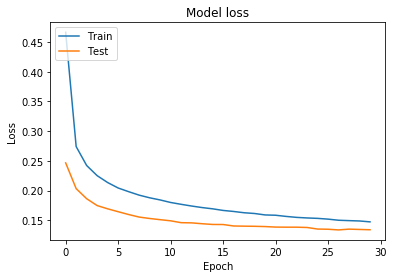

In [4]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Inference

In [23]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [24]:
def test_inference(test_words):
    encoder_input_test_data = np.zeros(
        (len(test_words), max_encoder_seq_length, num_encoder_tokens),
        dtype='float32')

    for i, word in enumerate(test_words):
        for t, char in enumerate(word):
            if char in input_token_index:
                encoder_input_test_data[i, t, input_token_index[char]] = 1.

    for idx in range(len(encoder_input_test_data)):
        print(test_words[idx],'->', decode_sequence(encoder_input_test_data[idx:idx+1]))
        
print("--Misspellings as input--")
test_inference([
    'acheive', 'apparantly', 'enviroment', 'goverment', 'persistant',
    'religous', 'wierd', 'truely', 'suprise', 'occurence'
])
print("--------------------------")
print("--Correct words as input--")
test_inference([
    'immediately', 'gist', 'embarrass', 'committee', 'assassination',
    'across', 'business', 'guard', 'knowledge', 'millennia'
])

--Misspellings as input--
acheive -> achieve

apparantly -> apparently

enviroment -> environment

goverment -> government

persistant -> persistent

religous -> religious

wierd -> wired

truely -> truly

suprise -> surprise

occurence -> occurrence

--------------------------
--Correct words as input--
immediately -> immediately

gist -> gist

embarrass -> embarrassed

committee -> committee

assassination -> assassination

across -> across

business -> business

guard -> guard

knowledge -> knowledge

millennia -> millennia

